# Deploy Stable Diffusion on AWS inferentia2 with Amazon SageMaker

In this end-to-end tutorial, you will learn how to deploy and speed up Stable Diffusion XL inference using AWS Inferentia2 and [optimum-neuron](https://huggingface.co/docs/optimum-neuron/index) on Amazon SageMaker. [Optimum Neuron](https://huggingface.co/docs/optimum-neuron/index) is the interface between the Hugging Face Transformers & Diffusers library and AWS Accelerators including AWS Trainium and AWS Inferentia2. 

You will learn how to: 

1. Convert Stable Diffusion XL to AWS Neuron (Inferentia2) with `optimum-neuron`
2. Create a custom `inference.py` script for Stable Diffusion
3. Upload the neuron model and inference script to Amazon S3
4. Deploy a Real-time Inference Endpoint on Amazon SageMaker
5. Generate images using the deployed model

## Quick intro: AWS Inferentia 2

[AWS inferentia (Inf2)](https://aws.amazon.com/de/ec2/instance-types/inf2/) are purpose-built EC2 for deep learning (DL) inference workloads. Inferentia 2 is the successor of [AWS Inferentia](https://aws.amazon.com/ec2/instance-types/inf1/?nc1=h_ls), which promises to deliver up to 4x higher throughput and up to 10x lower latency.

| instance size | accelerators | Neuron Cores | accelerator memory | vCPU | CPU Memory |
| ------------- | ------------ | ------------ | ------------------ | ---- | ---------- |
| inf2.xlarge   | 1            | 2            | 32                 | 4    | 16         |
| inf2.8xlarge  | 1            | 2            | 32                 | 32   | 128        |
| inf2.24xlarge | 6            | 12           | 192                | 96   | 384        |
| inf2.48xlarge | 12           | 24           | 384                | 192  | 768        |

Additionally, inferentia 2 will support the writing of custom operators in c++ and new datatypes, including `FP8` (cFP8).

Let's get started! 🚀

*If you are going to use Sagemaker in a local environment (not SageMaker Studio or Notebook Instances). You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.*

## 1. Convert Stable Diffusion to AWS Neuron (Inferentia2) with `optimum-neuron`

We are going to use the [optimum-neuron](https://huggingface.co/docs/optimum-neuron/index) to compile/convert our model to neuronx. Optimum Neuron provides a set of tools enabling easy model loading, training and inference on single- and multi-Accelerator settings for different downstream tasks. 

As a first step, we need to install the `optimum-neuron` and other required packages.

*Tip: If you are using Amazon SageMaker Notebook Instances or Studio you can go with the `conda_python3` conda kernel.*


In [ ]:
# Install the required packages
%pip install "optimum-neuron==0.0.11"  --upgrade diffusers==0.20.2 --upgrade
%pip install "sagemaker>=2.182.0"  --upgrade

After we have installed the `optimum-neuron` we can convert load and convert our model.

We are going to use the [stabilityai/stable-diffusion-xl-base-1.0](hstabilityai/stable-diffusion-xl-base-1.0) model. Stable Diffusion XL (SDXL) from [Stability AI](https://stability.ai/) is the newset text-to-image generation model, which can create photorealistic images with detailed imagery and composition compared to previous SD models, including SD 2.1.

In [6]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

At the time of writing, the [AWS Inferentia2 does not support dynamic shapes for inference](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/arch/neuron-features/dynamic-shapes.html?highlight=dynamic%20shapes#), which means that the we need to specify our image size in advanced for compiling and inference. 

In simpler terms, this means we need to define the input shapes for our prompt (sequence length), batch size, height and width of the image.

_Note: You need to use ~120GB of memory and the compilation can take 15-30 minutes. We used an `inf2.8xlarge` to compile the model. We are also working on pushing compiled checkpoints to the Hugging Face Hub, to skip this step._

In [ ]:
from optimum.neuron import NeuronStableDiffusionXLPipeline

# configs for compiling model
compiler_args = {"auto_cast": "all", "auto_cast_type": "bf16"}
input_shapes = {
  "height": 1024, # width of the image
  "width": 1024, # height of the image
  "sequence_length": 64, # sequence legnth for the input prompt
  "num_images_per_prompt": 1, # number of images to generate per prompt
  "batch_size": 1 # batch size for the model
  }

sd = NeuronStableDiffusionXLPipeline.from_pretrained(model_id, export=True, **input_shapes,**compiler_args)

# Save locally or upload to the HuggingFace Hub
save_directory = "sdxl_neuron"
sd.save_pretrained(save_directory)

# COMMENT IN TO UPLOAD TO HUB
# sd.push_to_hub(
#      save_directory, repository_id="my-neuron-repo", use_auth_token=True
# )

## 2. Create a custom `inference.py` script for Stable Diffusion

The [Hugging Face Inference Toolkit](https://github.com/aws/sagemaker-huggingface-inference-toolkit) supports zero-code deployments on top of the [pipeline feature](https://huggingface.co/transformers/main_classes/pipelines.html) from 🤗 Transformers. This allows users to deploy Hugging Face transformers without an inference script [[Example](https://github.com/huggingface/notebooks/blob/master/sagemaker/11_deploy_model_from_hf_hub/deploy_transformer_model_from_hf_hub.ipynb)]. 

Currently is this feature not supported with AWS Inferentia2, which means we need to provide an `inference.py` for running inference. But `optimum-neuron` has integrated support for the 🤗 Diffusers pipeline feature. That way we can use the `optimum-neuron` to create a pipeline for our model.

If you want to know more about the `inference.py` script check out this [example](https://github.com/huggingface/notebooks/blob/master/sagemaker/17_custom_inference_script/sagemaker-notebook.ipynb). It explains amongst other things what the `model_fn` and `predict_fn` are. 

In [3]:
# create code directory in our model directory
!mkdir {save_directory}/code

mkdir: cannot create directory ‘sdxl_neuron/code’: File exists


In addition to our `inference.py` script we need to provide a `requirements.txt`, which installs the latest version of the `optimum-neuron` package, which comes with `pipeline` support for AWS Inferentia2. 
_Note: This is a temporary solution until the `optimum-neuron` package is updated inside the DLC._

In [ ]:
%%writefile {save_directory}/code/requirements.txt
optimum-neuron==0.0.11
diffusers==0.20.2

We are using the `NEURON_RT_NUM_CORES=2` to make sure that each HTTP worker uses 2 Neuron core to maximize throughput.

In [ ]:
%%writefile {save_directory}/code/inference.py
import os
# To use two neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "2"
import torch
import torch_neuronx
import base64
from io import BytesIO
from optimum.neuron import NeuronStableDiffusionXLPipeline


def model_fn(model_dir):
    # load local converted model into pipeline
    pipeline = NeuronStableDiffusionXLPipeline.from_pretrained(model_dir, device_ids=[0, 1])
    return pipeline


def predict_fn(data, pipeline):
    # extract prompt from data
    prompt = data.pop("inputs", data)
    
    parameters = data.pop("parameters", None)
    
    if parameters is not None:
        generated_images = pipeline(prompt, **parameters)["images"]
    else:
        generated_images = pipeline(prompt)["images"]
        
    # postprocess convert image into base64 string
    encoded_images = []
    for image in generated_images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())

    # always return the first 
    return {"generated_images": encoded_images}

Before we can upload the model to Amazon S3 we have to create a `model.tar.gz` archive. Important is that the archive should directly contain all files and not a folder with the files. For example, your file should look like this:

In [12]:
# use pigz for faster and parallel compression
!cd {save_directory} && tar zcvf model.tar.gz *

code/
code/inference.py
code/requirements.txt
model_index.json
scheduler/
scheduler/scheduler_config.json
text_encoder/
text_encoder/model.neuron


text_encoder/config.json
text_encoder_2/
text_encoder_2/model.neuron
text_encoder_2/config.json
tokenizer/
tokenizer/tokenizer_config.json
tokenizer/special_tokens_map.json
tokenizer/merges.txt
tokenizer/vocab.json
tokenizer_2/
tokenizer_2/tokenizer_config.json
tokenizer_2/special_tokens_map.json
tokenizer_2/merges.txt
tokenizer_2/vocab.json
unet/
unet/model.neuron
unet/config.json
vae_decoder/
vae_decoder/model.neuron
vae_decoder/config.json
vae_encoder/
vae_encoder/model.neuron
vae_encoder/config.json


## 3. Upload the neuron model and inference script to Amazon S3

Before we can deploy our neuron model to Amazon SageMaker we need to upload it all our model artifacts to Amazon S3.

_Note: Currently `inf2` instances are only available in the `us-east-2` region [[REF](https://aws.amazon.com/de/about-aws/whats-new/2023/05/sagemaker-ml-inf2-ml-trn1-instances-model-deployment/)]. Therefore we need to force the region to us-east-2._

In [20]:
image = "754289655784.dkr.ecr.us-east-2.amazonaws.com/hf-internal-pytorch-neuronx-inference:1.13.1-transformers4.33.1-neuronx-py310-sdk2.13.2-ubuntu20.04-2023-09-19-09-17-41-multistage-common"
# image = "558105141721.dkr.ecr.us-east-2.amazonaws.com/neuronx-test:test"

Now lets create our SageMaker session and upload our model to Amazon S3.

In [21]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
# assert sess.boto_region_name in ["us-east-2", "us-west-2"] , "region must be us-east-2 or us-west-2, due to instance availability"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::754289655784:role/aws-reserved/sso.amazonaws.com/AWSReservedSSO_HfPowerUserAccess_52f2c0fa2c68efbe
sagemaker bucket: sagemaker-us-east-2-754289655784
sagemaker session region: us-east-2


Next, we upload our `sdxl_neuron` directory to Amazon S3 using our session bucket and `sagemaker` sdk.

In [22]:
iam = boto3.client('iam')

role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']


In [23]:
save_directory = "sdxl_neuron"

In [24]:
from sagemaker.s3 import S3Uploader

# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/neuronx/{model_id}"

# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path=f"{save_directory}/model.tar.gz" ,desired_s3_uri=s3_model_path)
print(f"model artifcats uploaded to {s3_model_uri}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


model artifcats uploaded to s3://sagemaker-us-east-2-754289655784/neuronx/stabilityai/stable-diffusion-xl-base-1.0/model.tar.gz


## 4. Deploy a Real-time Inference Endpoint on Amazon SageMaker

After we have uploaded our model artifacts to Amazon S3 can we create a custom `HuggingfaceModel`. This class will be used to create and deploy our real-time inference endpoint on Amazon SageMaker.

The `inf2.xlarge` instance type is the smallest instance type with AWS Inferentia2 support. It comes with 1 Inferentia2 chip with 2 Neuron Cores. This means we can use 2 Neuron Cores to minimize latency for our image generation. 

In [53]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
    model_data=s3_model_uri,
    role=role,                      # iam role with permissions to create an Endpoint
    image_uri=image,                # inference container
#    transformers_version="4.28.1",  # transformers version used
#    pytorch_version="1.13.0",       # pytorch version used
#    py_version='py38',              # python version used
   model_server_workers=1,         # number of workers for the model server
)

# Let SageMaker know that we've already compiled the model
huggingface_model._is_compiled_model = True

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,      # number of instances
    instance_type="ml.inf2.xlarge", # AWS Inferentia Instance
    volume_size = 100
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
--------------!

# 5.Generate images using the deployed model

The `.deploy()` returns an `HuggingFacePredictor` object which can be used to request inference. Our endpoint expects a `json` with at least `inputs` key. The `inputs` key is the input prompt for the model, which will be used to generate the image. Additionally, we can provide inference parameters, e.g. `num_inference_steps`.

The `predictor.predict()` function returns a `json` with the `generated_images` key. The `generated_images` key contains the `4` generated images as a `base64` encoded string. To decode our response we added a small helper function `decode_base64_to_image` which takes the `base64` encoded string and returns a `PIL.Image` object and `display_images`, which takes a list of `PIL.Image` objects and displays them.

In [54]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64
import matplotlib.pyplot as plt

# helper decoder
def decode_base64_image(image_string):
  base64_image = base64.b64decode(image_string)
  buffer = BytesIO(base64_image)
  return Image.open(buffer)

# display PIL images as grid
def display_images(images=None,columns=3):
    plt.figure(figsize=(20,20))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

Now, lets generate some images. As example lets generate `4` images for the prompt `A dog trying catch a flying pizza art drawn by disney concept artists`. Generating `4` images takes around `30` seconds.

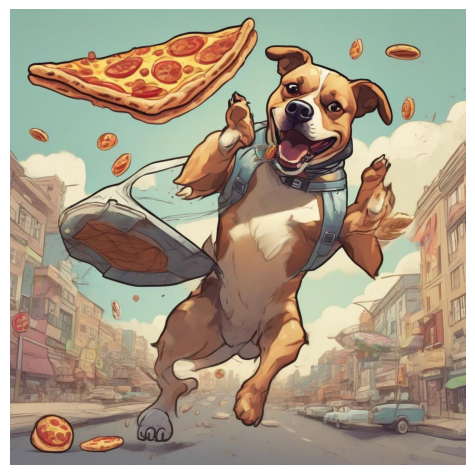

In [57]:
prompt = "A dog trying catch a flying pizza in style of comic book"

# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "parameters": {
    "num_inference_steps" : 25,
    } 
  }
)

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
display_images(decoded_images)

### Delete model and endpoint

To clean up, we can delete the model and endpoint.

In [58]:
predictor.delete_model()
predictor.delete_endpoint()